In [1]:
import xarray
from distributed import Client
import regionmask
import cartopy.crs as ccrs
import cftime
import numpy as np
from os import listdir
import sys
sys.path.insert(1, '../src/')
import hdp


client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=80>

In [2]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs


f_background_color = "#ffffff"
ax_background_color = "#ffffff"
all_color = "Black"
xaer_color = "Blue"
grid_line_color = "#e8e8e8"
grid_line_lw = 0.8

In [3]:
path = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/"
listdir(path)

['all_day_TREFHTMN.zarr',
 'preindustrial_day_TREFHTMX.zarr',
 'xghg_day_TREFHTMN.zarr',
 'xaer_day_TREFHTMX.zarr',
 'all_day_TREFHTMX.zarr',
 'preindustrial_day_TREFHTMN.zarr',
 'xaer_day_TREFHTMN.zarr',
 'xghg_day_TREFHTMX.zarr']

In [4]:
pic_cesm1_trefhtmx = xarray.open_zarr(f"{path}preindustrial_day_TREFHTMX.zarr")["TREFHTMX"]
all_cesm1_trefhtmx = xarray.open_zarr(f"{path}all_day_TREFHTMX.zarr")["TREFHTMX"].sel(member='001')
xaer_cesm1_trefhtmx = xarray.open_zarr(f"{path}xaer_day_TREFHTMX.zarr")["TREFHTMX"].sel(member='001')

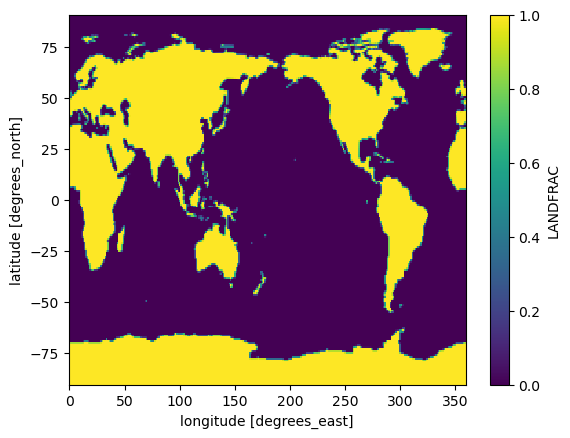

In [7]:
landfrac_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/"
cesm1_landfrac = xarray.open_dataset(f"{landfrac_path}b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc")["LANDFRAC"].mean(dim="time")
cesm1_landfrac.plot();

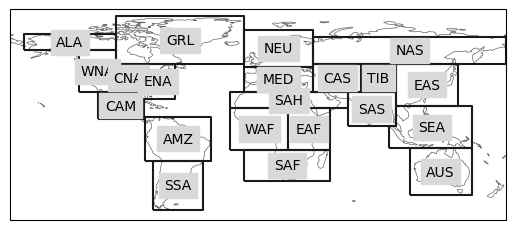

In [8]:
regionmask.defined_regions.giorgi.plot(label='abbrev');

In [10]:
sas_mask = (regionmask.defined_regions.giorgi.mask(pic_cesm1_trefhtmx) == 18)
slice_start = cftime.DatetimeNoLeap(1800, 1, 1, 0, 0, 0, 0, has_year_zero=True)
slice_end = cftime.DatetimeNoLeap(1899, 12, 31, 0, 0, 0, 0, has_year_zero=True)


pic_cesm1_trefhtmx_sub = pic_cesm1_trefhtmx.where(cesm1_landfrac > 0).where(sas_mask, drop=True).sel(time=slice(slice_start, slice_end))
all_cesm1_trefhtmx_sub = all_cesm1_trefhtmx.where(cesm1_landfrac > 0).where(sas_mask, drop=True)
xaer_cesm1_trefhtmx_sub = xaer_cesm1_trefhtmx.where(cesm1_landfrac > 0).where(sas_mask, drop=True)

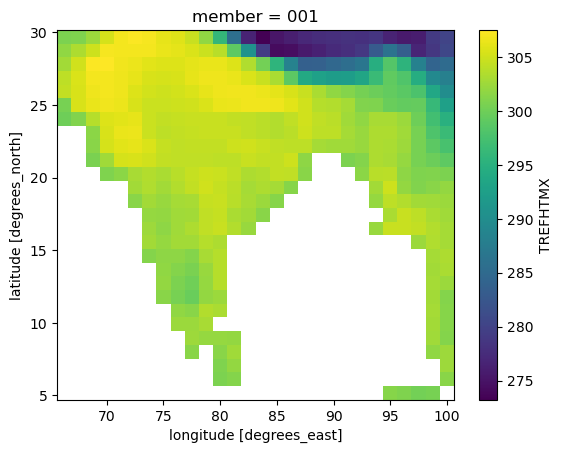

In [12]:
all_cesm1_trefhtmx_sub.mean(dim=["time"]).plot();

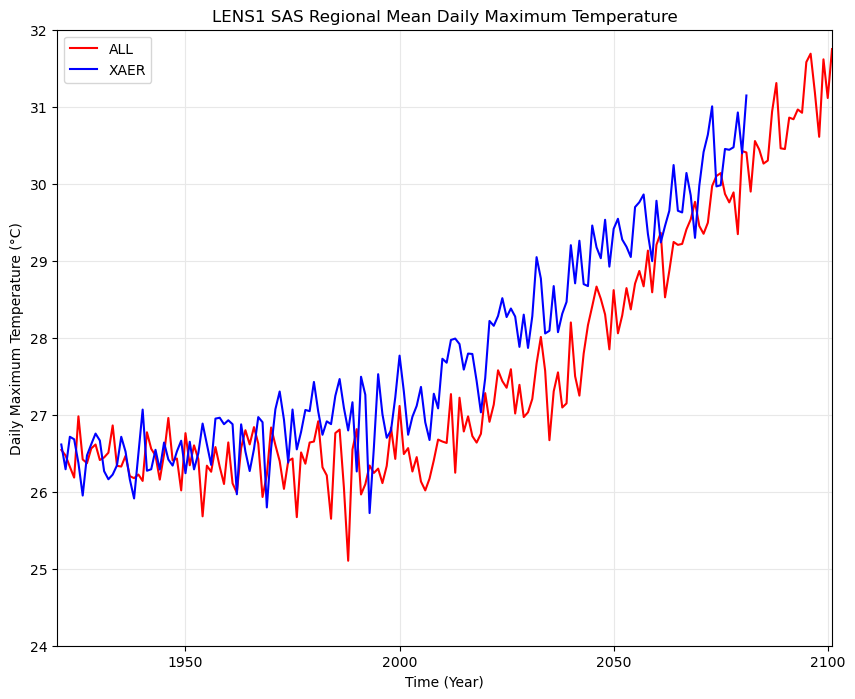

In [13]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

(all_cesm1_trefhtmx_sub.mean(dim=["lat", "lon"]).resample(time="YE").mean() - 273.15).plot(ax=ax1, color="Red", label="ALL")
(xaer_cesm1_trefhtmx_sub.mean(dim=["lat", "lon"]).resample(time="YE").mean() - 273.15).plot(ax=ax1, color="Blue", label="XAER")


for i in ax1.get_xticks():
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in ax1.get_yticks():
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

ax1.set_xlim(all_cesm1_trefhtmx_sub.time.values[0], all_cesm1_trefhtmx_sub.time.values[-1])
ax1.set_ylim(24, 32)
ax1.set_xlabel("Time (Year)")
ax1.set_ylabel("Daily Maximum Temperature (°C)")
ax1.set_title("LENS1 SAS Regional Mean Daily Maximum Temperature")
ax1.legend()

In [14]:
definitions = []
for min_duration in np.arange(2, 8):
    for max_break in np.arange(0, 4):
        definitions.append([min_duration, max_break])
definitions = np.array(definitions)
definitions.shape

(24, 2)

In [22]:
xarray.DataArray(data=np.zeros((10,10)))

<xarray.DataArray (dim_0: 10, dim_1: 10)> Size: 800B
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Dimensions without coordinates: dim_0, dim_1

In [15]:
%%time
heatwave_threshold = hdp.compute_threshold(pic_cesm1_trefhtmx_sub, np.arange(0.9, 1, 0.01))
all_heatwave_metrics = hdp.compute_heatwave_metrics_dask(all_cesm1_trefhtmx_sub, heatwave_threshold["threshold"], definitions)
xaer_heatwave_metrics = hdp.compute_heatwave_metrics_dask(xaer_cesm1_trefhtmx_sub, heatwave_threshold["threshold"], definitions)

CPU times: user 1.51 s, sys: 21.9 ms, total: 1.53 s
Wall time: 1.53 s


In [19]:
%%time
heatwave_threshold = heatwave_threshold.compute()
all_heatwave_metrics = all_heatwave_metrics.compute()
xaer_heatwave_metrics = xaer_heatwave_metrics.compute()

CPU times: user 648 ms, sys: 216 ms, total: 864 ms
Wall time: 3min 41s


In [ ]:
f = plt.figure(figsize=(20, 8), facecolor='w')

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())


for perc in heatwave_threshold.percentile.values:
    (heatwave_threshold["threshold"].sel(percentile=perc).mean(dim=["lat", "lon"]) - 273.15).plot(ax=ax1, label='{0:.{1}f}th'.format(perc*100, 0))


f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

ax1.legend(fontsize=15)
ax1.set_title("Regional Mean Percentile Thresholds", fontsize=18, pad=15)
ax1.set_xlabel("Time (Day of Year)", fontsize=14)
ax1.set_ylabel("Daily Maximum Temperature (°C)", fontsize=14)
ax1.set_xlim(0, 365)

for i in ax1.get_xticks():
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in ax1.get_yticks():
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

levels = np.arange(-20, 31, 2.5)
(heatwave_threshold["threshold"].sel(percentile=0.9, day=0) - 273.15).rename("Daily Maximum Temperature (°C)").plot.contourf(ax=ax2, cmap="Reds", transform=ccrs.PlateCarree(), levels=levels)

ax2.set_title("Regional 90th Percentile, January 1st Thresholds", fontsize=18, pad=15, y=1.25)
ax2.coastlines()
f.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')

all_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="2-0").mean(dim=["lat", "lon"]).plot(ax=ax1, label=f"90th Perc., Def. 2-0")
all_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="4-0").mean(dim=["lat", "lon"]).plot(ax=ax1, label=f"90th Perc., Def. 4-0")
all_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="7-0").mean(dim=["lat", "lon"]).plot(ax=ax1, label=f"90th Perc., Def. 7-0")

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

ax1.legend(fontsize=15)
ax1.set_title("LENS1 ALL, Member 001, Regional Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("HWF (Heatwave Days)", fontsize=14)
ax1.set_xlim(1920, 2080)
ax1.set_ylim(0, 80)

for i in ax1.get_xticks():
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in ax1.get_yticks():
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

xaer_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="2-0").mean(dim=["lat", "lon"]).plot(ax=ax2, label=f"90th Perc., Def. 2-0")
xaer_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="4-0").mean(dim=["lat", "lon"]).plot(ax=ax2, label=f"90th Perc., Def. 4-0")
xaer_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="7-0").mean(dim=["lat", "lon"]).plot(ax=ax2, label=f"90th Perc., Def. 7-0")

ax2.set_facecolor(ax_background_color)

ax2.legend(fontsize=15)
ax2.set_title("LENS1 XAER, Member 001, Regional Mean Heatwave Frequency", fontsize=18, pad=15)
ax2.set_xlabel("Time (Year)", fontsize=14)
ax2.set_ylabel("HWF (Heatwave Days)", fontsize=14)
ax2.set_xlim(1920, 2080)
ax2.set_ylim(0, 80)

for i in ax2.get_xticks():
    ax2.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in ax2.get_yticks():
    ax2.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

f.show()

In [ ]:
aer_heatwave_metrics = all_heatwave_metrics - xaer_heatwave_metrics

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')

aer_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="2-1").mean(dim=["lat", "lon"]).plot(ax=ax1, label=f"90th Perc., Def. 2-1")
aer_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="4-1").mean(dim=["lat", "lon"]).plot(ax=ax1, label=f"90th Perc., Def. 4-1")
aer_heatwave_metrics["HWF"].sel(percentile=0.9).sel(definition="7-1").mean(dim=["lat", "lon"]).plot(ax=ax1, label=f"90th Perc., Def. 7-1")

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

ax1.legend(fontsize=15)
ax1.set_title("LENS1 ALL-XAER (AER), Member 001, Regional Mean Change in Heatwave Frequency", fontsize=14, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ HWF (Heatwave Days)", fontsize=14)
ax1.set_xlim(1920, 2080)
ax1.set_ylim(-30, 30)

for i in ax1.get_xticks():
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in ax1.get_yticks():
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

aer_heatwave_metrics["HWD"].sel(percentile=0.9).sel(definition="2-0").mean(dim=["lat", "lon"]).plot(ax=ax2, label=f"90th Perc., Def. 2-0")
aer_heatwave_metrics["HWD"].sel(percentile=0.9).sel(definition="4-0").mean(dim=["lat", "lon"]).plot(ax=ax2, label=f"90th Perc., Def. 4-0")
aer_heatwave_metrics["HWD"].sel(percentile=0.9).sel(definition="7-0").mean(dim=["lat", "lon"]).plot(ax=ax2, label=f"90th Perc., Def. 7-0")

f.patch.set_facecolor(f_background_color)
ax2.set_facecolor(ax_background_color)

ax2.legend(fontsize=15)
ax2.set_title("LENS1 ALL-XAER (AER), Member 001, Regional Mean Change in Heatwave Duration", fontsize=14, pad=15)
ax2.set_xlabel("Time (Year)", fontsize=14)
ax2.set_ylabel("Δ HWD (Heatwave Days)", fontsize=14)
ax2.set_xlim(1920, 2080)
ax2.set_ylim(-30, 30)

for i in ax2.get_xticks():
    ax2.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in ax2.get_yticks():
    ax2.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16), facecolor='w')

levels = np.arange(0, -71, -5)
cmap = "Blues_r"

all_slice = all_heatwave_metrics.sel(year=slice(2005, 2080)).mean(dim=["lat", "lon", "year"])
aer_slice = aer_heatwave_metrics.sel(year=slice(2005, 2080)).mean(dim=["lat", "lon", "year"])
aer_perc_change = 100*(aer_slice / all_slice)
aer_perc_change["HWF"].rename("Percent Change in Heatwave Frequency (%)").plot.contourf(cmap=cmap, levels=levels, ax=ax1)

ax1.set_ylabel("Definition (Min. # of Days - Max. Break)")
ax1.set_xlabel("Percentile ([0, 1])")
ax1.set_title("LENS1 ALL-XAER (AER), Member 001, Mean Change in HWF 2005-2080", fontsize=16, pad=15)

all_slice = all_heatwave_metrics.sel(year=slice(2005, 2080)).mean(dim=["lat", "lon", "year"])
aer_slice = aer_heatwave_metrics.sel(year=slice(2005, 2080)).mean(dim=["lat", "lon", "year"])
aer_perc_change = 100*(aer_slice / all_slice)
aer_perc_change["HWD"].rename("Percent Change in Heatwave Duration (%)").plot.contourf(cmap=cmap, levels=levels, ax=ax2)

ax2.set_ylabel("Definition (Min. # of Days - Max. Break)")
ax2.set_xlabel("Percentile ([0, 1])")
ax2.set_title("LENS1 ALL-XAER (AER), Member 001, Mean Change in HWD 2005-2080", fontsize=16, pad=15)

all_slice = all_heatwave_metrics.sel(year=slice(1930, 2004)).mean(dim=["lat", "lon", "year"])
aer_slice = aer_heatwave_metrics.sel(year=slice(1930, 2004)).mean(dim=["lat", "lon", "year"])
aer_perc_change = 100*(aer_slice / all_slice)
aer_perc_change["HWF"].rename("Percent Change in Heatwave Frequency (%)").plot.contourf(cmap=cmap, levels=levels, ax=ax3)

ax3.set_ylabel("Definition (Min. # of Days - Max. Break)")
ax3.set_xlabel("Percentile ([0, 1])")
ax3.set_title("LENS1 ALL-XAER (AER), Member 001, Mean Change in HWF 1930-2004", fontsize=16, pad=15)

all_slice = all_heatwave_metrics.sel(year=slice(1930, 2004)).mean(dim=["lat", "lon", "year"])
aer_slice = aer_heatwave_metrics.sel(year=slice(1930, 2004)).mean(dim=["lat", "lon", "year"])
aer_perc_change = 100*(aer_slice / all_slice)
aer_perc_change["HWD"].rename("Percent Change in Heatwave Duration (%)").plot.contourf(cmap=cmap, levels=levels, ax=ax4)

ax4.set_ylabel("Definition (Min. # of Days - Max. Break)")
ax4.set_xlabel("Percentile ([0, 1])")
ax4.set_title("LENS1 ALL-XAER (AER), Member 001, Mean Change in HWD 1930-2004", fontsize=16, pad=15);